In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json


## Pre-processamento

In [0]:
df = pd.read_csv('USvideos.csv')

In [5]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [7]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


In [0]:
def count_unique(x):
  for col in x.columns:
    print(f'{col}: {x[col].nunique()}')

In [9]:
count_unique(df)

video_id: 6351
trending_date: 205
title: 6455
channel_title: 2207
category_id: 16
publish_time: 6269
tags: 6055
views: 40478
likes: 29850
dislikes: 8516
comment_count: 13773
thumbnail_link: 6352
comments_disabled: 2
ratings_disabled: 2
video_error_or_removed: 2
description: 6901


In [10]:
# Drop columns with no important information in our analysis:
#thumbnail_link: link to small image which identify the video in the search results

df.drop(columns='thumbnail_link', inplace=True)
print(df.columns)

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description'],
      dtype='object')


In [0]:
# Read json with category_id names and assign the names in new dataframe column 

import json

# open json file with category names
with open('US_category_id.json', 'r') as f:
  categ_us = json.load(f)

categ_dic = {}

for k in categ_us['items']:
  categ_dic[k['id']]= k['snippet']['title']

#print(categ_dic)

# Creating new column with category names
temp = df.category_id.copy()
temp = temp.astype('str')
df['category_name'] = temp.map(categ_dic)

#print(df.loc[:10, ['category_id', 'category_name']])



Text(0, 0.5, 'Category')

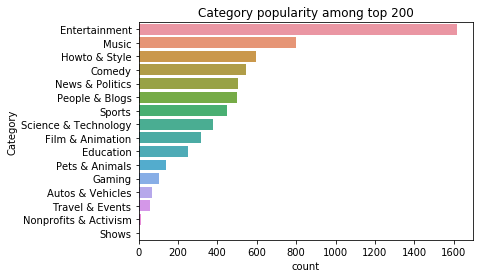

In [16]:
df2 = df.copy()
df2.drop_duplicates('video_id', inplace=True)
sns.countplot(y='category_name', data=df2, order=df2.category_name.value_counts().index )
plt.title('Category popularity among top 200')
plt.ylabel('Category')

### Temporal distributions

Total samples per year:
 2018    31349
2017     9600
Name: trending_date, dtype: int64


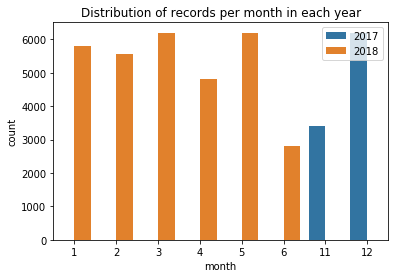

In [18]:
# Processing the time feature

df.trending_date = pd.to_datetime(df.trending_date, format='%y.%d.%m')

year_counts = df.trending_date.dt.year.value_counts()
print('Total samples per year:\n', year_counts) 

df['year'] = df.trending_date.dt.year
df['month'] = df.trending_date.dt.month

# Plot distribution of records per time 
sns.countplot(data=df, x = 'month', hue='year')
plt.title('Distribution of records per month in each year')
plt.legend(['2017', '2018'])


## Popularity

Text(0.5, 1.0, 'Most viewed videos')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

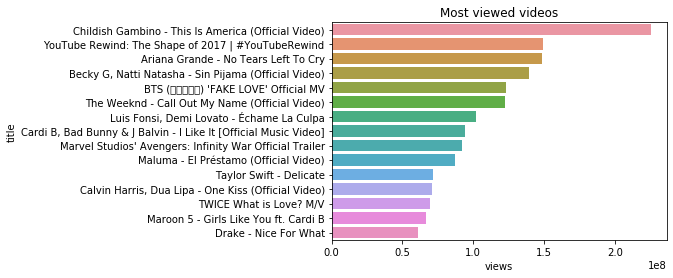

In [58]:
# Per views
df2 = df.copy()

df2.sort_values('views', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

sns.barplot(y='title', x='views', data=df2.iloc[:15])
plt.title('Most viewed videos')

#TODO: warnings caused by presence of not roman font!

In [22]:
df2.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
38547,VYOjWnS4cMY,2018-06-02,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,False,False,False,“This is America” by Childish Gambino http://s...,Music,2018,6
6181,FlsCjmMhFmw,2017-12-14,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",149376127,3093544,1643059,810698,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
34708,ffxKSjUwKdU,2018-05-14,Ariana Grande - No Tears Left To Cry,ArianaGrandeVevo,10,2018-04-20T04:00:03.000Z,"Ariana|""Grande""|""No""|""Tears""|""Left""|""To""|""Cry""...",148689896,3094021,129502,242039,False,False,False,No Tears Left To Cry (Official Video)Song Avai...,Music,2018,5
34888,zEf423kYfqk,2018-05-15,"Becky G, Natti Natasha - Sin Pijama (Official ...",BeckyGVEVO,10,2018-04-20T10:40:51.000Z,"Becky G|""Natti Natasha""|""Natti Natasha Music""|...",139334502,1425496,119798,83941,False,False,False,Becky G & Natti Natasha – “Sin Pijama”NUEVO SE...,Music,2018,5
38273,7C2z4GqqS5E,2018-06-01,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",123010920,5613827,206892,1228655,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Music,2018,6
34747,M4ZoCHID9GI,2018-05-14,The Weeknd - Call Out My Name (Official Video),TheWeekndVEVO,10,2018-04-12T16:00:04.000Z,"The|""Weeknd""|""Call""|""Out""|""My""|""Name""",122544931,1427436,40837,55320,False,False,False,Call Out My Name (Official Video)Taken from th...,Music,2018,5
2587,TyHvyGVs42U,2017-11-26,"Luis Fonsi, Demi Lovato - Échame La Culpa",LuisFonsiVEVO,10,2017-11-17T05:00:01.000Z,"Luis|""Fonsi""|""Demi""|""Lovato""|""Échame""|""La""|""Cu...",102012605,2376636,117196,134224,False,False,False,“Échame La Culpa” disponible ya en todas las p...,Music,2017,11
40869,xTlNMmZKwpA,2018-06-14,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...",Cardi B,10,2018-05-29T14:05:10.000Z,"Cardi B|""I Like It""|""Invasion of Privacy""|""Bad...",94254507,1816753,102474,101077,False,False,False,"Cardi B, Bad Bunny & J Balvin - I Like It from...",Music,2018,6
4997,6ZfuNTqbHE8,2017-12-08,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",91933007,2625661,53709,350458,False,False,False,There was an idea… Avengers: Infinity War. In ...,Entertainment,2017,12
25947,-BQJo3vK8O8,2018-03-25,Maluma - El Préstamo (Official Video),MalumaVEVO,10,2018-03-09T11:00:01.000Z,"Maluma Music|""Maluma Official Video""|""Maluma V...",87264467,815369,71494,35945,False,False,False,Maluma - El Prestamo (Official Music Video)\nE...,Music,2018,3


In [42]:
# Per likes
df2 = df.copy()

df2.sort_values('likes', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

df2.head()

          video_id trending_date  ...  year month
38273  7C2z4GqqS5E    2018-06-01  ...  2018     6
38547  VYOjWnS4cMY    2018-06-02  ...  2018     6
34708  ffxKSjUwKdU    2018-05-14  ...  2018     5
6181   FlsCjmMhFmw    2017-12-14  ...  2017    12
3581   kTlv5_Bs8aw    2017-12-01  ...  2017    12
35080  p8npDG2ulKQ    2018-05-16  ...  2018     5
22040  OK3GJ0WIQ8s    2018-03-06  ...  2018     3
4997   6ZfuNTqbHE8    2017-12-08  ...  2017    12
39814  aJOTlE1K90k    2018-06-09  ...  2018     6
2587   TyHvyGVs42U    2017-11-26  ...  2017    11

[10 rows x 18 columns]


In [44]:
# Per dislikes
df2 = df.copy()

df2.sort_values('dislikes', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

df2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
11323,QwZT7T-TXT0,2018-01-09,So Sorry.,Logan Paul Vlogs,24,2018-01-02T16:42:21.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""o...",37539570,1402578,1674420,1361580,False,False,False,NaN,Entertainment,2018,1
6181,FlsCjmMhFmw,2017-12-14,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",149376127,3093544,1643059,810698,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
15571,oWjxSkJpxFU,2018-02-01,Suicide: Be Here Tomorrow.,Logan Paul Vlogs,29,2018-01-24T18:30:01.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""l...",24286474,1988746,497847,658130,False,False,False,National Suicide Prevention Lifeline\nCall 1-8...,Nonprofits & Activism,2018,2
38547,VYOjWnS4cMY,2018-06-02,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,False,False,False,“This is America” by Childish Gambino http://s...,Music,2018,6
17063,_5d-sQ7Fh5M,2018-02-09,LOGAN PAUL IS BACK!,Logan Paul Vlogs,24,2018-02-04T22:02:27.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""o...",14161833,1216340,291900,436698,False,False,False,Do It Different. Be a Maverick ► https://ShopL...,Entertainment,2018,2


In [46]:
# Per comments
df2 = df.copy()

df2.sort_values('comment_count', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

df2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
11323,QwZT7T-TXT0,2018-01-09,So Sorry.,Logan Paul Vlogs,24,2018-01-02T16:42:21.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""o...",37539570,1402578,1674420,1361580,False,False,False,NaN,Entertainment,2018,1
38273,7C2z4GqqS5E,2018-06-01,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",123010920,5613827,206892,1228655,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Music,2018,6
5020,FlsCjmMhFmw,2017-12-09,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",75969469,2251797,1127798,827755,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
15571,oWjxSkJpxFU,2018-02-01,Suicide: Be Here Tomorrow.,Logan Paul Vlogs,29,2018-01-24T18:30:01.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""l...",24286474,1988746,497847,658130,False,False,False,National Suicide Prevention Lifeline\nCall 1-8...,Nonprofits & Activism,2018,2
3581,kTlv5_Bs8aw,2017-12-01,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10,2017-11-24T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",36857298,2729292,47896,546100,False,False,False,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Music,2017,12


Text(0.5, 1.0, 'Channel popularity among top 200')

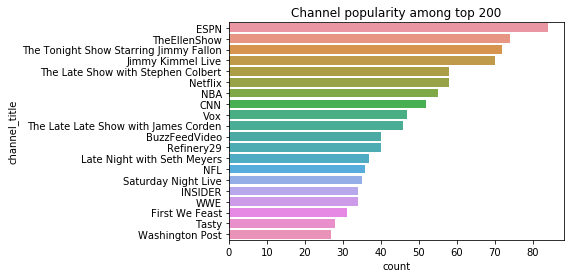

In [40]:
# Per channel
df2 = df.copy()

df2.drop_duplicates('video_id', inplace=True)

sns.countplot(y='channel_title', data=df2, order=df2.channel_title.value_counts().iloc[:20].index)
plt.title('Channel popularity among top 200')


In [0]:
# Divide per year 
df_2017 = df[df.trending_date.dt.year == 2017]
df_2018 = df[df.trending_date.dt.year == 2018]


Video popularity rank varies a lot between the months

In [0]:
# 2017
var = 'likes'
mon = 12 #11-12

In [0]:
df_2017.loc[df.trending_date.dt.month == mon, ['video_id', 'title', var]].groupby(['video_id', 'title']).sum().sort_values(var, ascending = False).head(10)

In [0]:
# 2018
var = 'likes'
mon = 1 # 1-6

In [0]:
df_2018.loc[df.trending_date.dt.month == mon, ['video_id', 'title', var]].groupby(['video_id', 'title']).sum().sort_values(var, ascending = False)[:10]